In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.integrate import simps
from scipy.optimize import brentq

import sys
import dill

from functools import partial
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

In [3]:
labelsize = 18
titlesize = 20

In [4]:
sys.path.append('..')

In [5]:
from finance.discountfactor import ConstantRateDiscountFactor
from finance.products.european.swap import SwapContract
from utils import time_offseter

loaded_data = None

with open('precomputed_sims/data1.pkl', 'rb') as f:
    loaded_data = dill.load(f)
    
step = 1 / 360.
delta = 5 * step

maturity = loaded_data["randomization"]["maturity"]
print "Maturity = %s years" % maturity

r = 0.02
discount = ConstantRateDiscountFactor(r)

udlyings = loaded_data["underlyings"]
print "Maximum number of paths: %i" % len(udlyings)

GBM0 = udlyings[0]
kappa = GBM0.drifts[0][0]
sigma = GBM0.vols[0][0]
print "kappa = %s, sigma = %s" % (kappa, sigma)

time_grid = GBM0.time

derivatives_nb = 1

swap_delta = 0.25
swap_dates = SwapContract.generate_payment_dates(0, maturity, swap_delta)
swap = SwapContract(GBM0, discount, swap_dates)

print swap

p_fixed = 1.
strike = swap.strike

delta_times = swap.delta_time
discount_factors = [discount(t) for t in swap.pillars[1:]]

delta_beta_sum = np.dot(delta_times, discount_factors)

notional = p_fixed / (strike * delta_beta_sum)

print "Notional on the swap: %s" % notional

copula = loaded_data["credit"]["copula"]
c_subsets_indexes = loaded_data["credit"]["bc_subsets_indexes"]
obligors_nb = len(copula.subsets[c_subsets_indexes[-1]][0])
print "Obligor numbers: %s" % obligors_nb

c_ids = [17, 9, 29, 26, 50, 4, 5, 13, 64]
c_positions = [0.69, -0.46, -0.44, -0.36, 0.34, 0.23, 0.09, -0.05, -0.04]

print "Counterparties id: %s (nb = %s)" % (c_ids, len(c_ids))

POSITIONS = np.zeros(obligors_nb)
for idx, ps in zip(c_ids, c_positions):
    POSITIONS[idx] = ps

POSITIONS = POSITIONS / -POSITIONS[13]
POSITIONS = np.array(POSITIONS).flatten()

print POSITIONS

spreads = [176, 45, 367, 1053, 73, 56, 52, 61, 108]
IDS_SPREADS = dict((id_, spread_) for (id_, spread_) in zip(c_ids, spreads))
IDS_POSITIONS = dict((id_, pos_) for (id_, pos_) in zip(c_ids, c_positions))

Maturity = 5.0 years
Maximum number of paths: 20000
kappa = 0.12, sigma = 0.2
Swap contract of maturity T = 5 years, over S^0 with strike K = 134.306, paying at {0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00}
Notional on the swap: 0.0015687485053
Obligor numbers: 125
Counterparties id: [17, 9, 29, 26, 50, 4, 5, 13, 64] (nb = 9)
[  0.    0.    0.    0.    4.6   1.8   0.    0.    0.   -9.2   0.    0.
   0.   -1.    0.    0.    0.   13.8   0.    0.    0.    0.    0.    0.
   0.    0.   -7.2   0.    0.   -8.8   0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    6.8   0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.   -0.8   0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    

In [6]:
QUANTILES = np.linspace(0.85, 0.997, 20)
print QUANTILES
print
LOIM_PATH = './res/aggregated/loss_over_im'

HURDLE_RATE = 0.1

times_cva = np.arange(0, maturity, 0.5)

shifted_times_cva = times_cva + 1.
shifted_times_cva[-1] = maturity

[ 0.85        0.85773684  0.86547368  0.87321053  0.88094737  0.88868421
  0.89642105  0.90415789  0.91189474  0.91963158  0.92736842  0.93510526
  0.94284211  0.95057895  0.95831579  0.96605263  0.97378947  0.98152632
  0.98926316  0.997     ]



In [7]:
def fact_(swap_, discount_, kappa_, delta_, t_):
    time_grid_ = swap_.underlying.time
    t_delta_ = time_offseter(t_ + delta_, time_grid_, True)
    
    coupon_dates_ = swap_.pillars
    l_t_delta_ = np.searchsorted(coupon_dates_, t_delta_, side='left')

    beta_T_l_ = map(discount_, coupon_dates_[l_t_delta_ + 1 :])    
    h_l_ = swap_.delta_time[l_t_delta_ : ]
    
    T_l_m1_ = kappa_ * coupon_dates_[l_t_delta_ : -1]
    exp_factor_ = map(np.exp, T_l_m1_)
    
    tmp_ = np.multiply(exp_factor_, h_l_)    
    res_ = np.dot(beta_T_l_, tmp_)
    
    return res_

fact = partial(fact_, swap, discount, kappa, delta)

In [8]:
def B_(fact_f_, vol_, delta_, a_, omega_, t_):
    if a_ <= 0.5: 
        a_ = 1. - a_
    
    perc_ = a_ if omega_ <= 0. else (1. - a_)
    q_ = norm.ppf(perc_)
    
    var_ = vol_**2 * delta_
    exp_factor_ = np.exp(-0.5 * var_ + np.sqrt(var_) * q_)
    
    tmp_res_ = 1. - exp_factor_
    
    return np.sign(omega_) * tmp_res_ * fact_f_(t_)

B = partial(B_, fact, sigma, delta)

In [9]:
def map_id_label(c_id_):
    pos_ = POSITIONS[c_id_]
    spread_ =  IDS_SPREADS[c_id_]
    
    pos_string_ = "%.2f" % abs(pos_)
    if pos_ < 0:
        pos_string_ = "(" + pos_string_ + ")"
    
    return '%i bps \n%s' % (spread_, pos_string_) 

In [10]:
def str_quantile(x):
    q = x * 100
    str_q = '%.1f' % q
    if str_q[-1] == '0':
        return str_q[:-2] + '%'
    
    return str_q + '%'

In [11]:
def compute_im0(sorted_bc_ids_):
    df_im0 = pd.DataFrame()
    S0 = GBM0(0.)[0, 0]
    
    for alpha in QUANTILES:
        for id_ in sorted_bc_ids_:
            label_id_ = map_id_label(id_)
            
            pos_ = POSITIONS[id_]
            nom_i = np.abs(pos_) * notional
            
            im0 = S0 * nom_i * B(alpha, pos_, 0.)
            
            df_im0.set_value(label_id_, str_quantile(alpha), im0)
            
    return df_im0

In [12]:
im0 = compute_im0(c_ids)

im0 = im0.transpose()
im0['Total IM'] = im0.sum(axis=1)

im0 = im0.transpose()

im0
#im0.plot.bar(rot=0);

,85%,85.8%,86.5%,87.3%,88.1%,88.9%,89.6%,90.4%,91.2%,92%,92.7%,93.5%,94.3%,95.1%,95.8%,96.6%,97.4%,98.2%,98.9%,99.7%
176 bps \n13.80,0.323634,0.333929,0.344601,0.355695,0.367260,0.379357,0.392061,0.405460,0.419664,0.434814,0.451091,0.468731,0.488061,0.509541,0.533856,0.562095,0.596159,0.639873,0.703141,0.835121
45 bps \n(9.20),0.216120,0.223332,0.230822,0.238620,0.246763,0.255298,0.264277,0.273766,0.283848,0.294626,0.306233,0.318847,0.332709,0.348161,0.365716,0.386189,0.411006,0.443049,0.489822,0.588923
367 bps \n(8.80),0.206723,0.213622,0.220786,0.228245,0.236034,0.244198,0.252786,0.261863,0.271507,0.281816,0.292919,0.304984,0.318243,0.333024,0.349815,0.369398,0.393136,0.423786,0.468525,0.563318
1053 bps \n(7.20),0.169137,0.174782,0.180643,0.186746,0.193119,0.199798,0.206825,0.214252,0.222142,0.230577,0.239661,0.249532,0.260381,0.272474,0.286213,0.302235,0.321657,0.346734,0.383339,0.460896
73 bps \n6.80,0.159472,0.164545,0.169803,0.175270,0.180969,0.186930,0.193189,0.199792,0.206791,0.214256,0.222276,0.230969,0.240494,0.251078,0.263060,0.276975,0.293760,0.315300,0.346475,0.411509
56 bps \n4.60,0.107878,0.111310,0.114867,0.118565,0.122420,0.126452,0.130687,0.135153,0.139888,0.144938,0.150364,0.156244,0.162687,0.169847,0.177952,0.187365,0.198720,0.213291,0.234380,0.278374
52 bps \n1.80,0.042213,0.043556,0.044948,0.046395,0.047903,0.049481,0.051138,0.052886,0.054739,0.056715,0.058838,0.061139,0.063660,0.066462,0.069633,0.073317,0.077760,0.083462,0.091714,0.108929
61 bps \n(1.00),0.023491,0.024275,0.025089,0.025937,0.026822,0.027750,0.028726,0.029757,0.030853,0.032025,0.033286,0.034657,0.036164,0.037844,0.039752,0.041977,0.044675,0.048158,0.053241,0.064013
108 bps \n(0.80),0.018793,0.019420,0.020071,0.020750,0.021458,0.022200,0.022981,0.023806,0.024682,0.025620,0.026629,0.027726,0.028931,0.030275,0.031801,0.033582,0.035740,0.038526,0.042593,0.051211
Total IM,1.267460,1.308771,1.351631,1.396221,1.442748,1.491465,1.542671,1.596735,1.654114,1.715387,1.781296,1.852829,1.931330,2.018706,2.117799,2.233132,2.372612,2.552178,2.813231,3.362293


In [13]:
def objective_es_quantile(q_, total_im, serie_, coeff_):
    var_ = serie_.quantile(q_, interpolation='linear')
    es_ = serie_[serie_ >= var_].mean()
    
    return es_ - coeff_ * total_im

In [14]:
def map_es0_quantile(q, coeff):
    str_int = '[0.00, 1.00]'
    fname = 'loim_%s_%s.csv' % (str_int, q)
    loim_q_path = os.path.join(LOIM_PATH, fname)
    loim_df = pd.read_csv(loim_q_path, header=0, index_col=0)
    
    loim_ser = loim_df.sum(axis=1)
    
    total_im = im0[str_quantile(q)]['Total IM']
    
    res = brentq(objective_es_quantile, 0., 1., args=(total_im, loim_ser, coeff))
    return res

In [15]:
ES_QUANTILES = {}
for coeff in [0.1, 0.15, 0.3, 0.5]:
    #ES_QUANTILES[coeff] = map(lambda x: map_es0_quantile(x, coeff), QUANTILES)
    ES_QUANTILES[coeff] = []
    for q in QUANTILES:
        try:
            ES_QUANTILES[coeff].append(map_es0_quantile(q, coeff))
        except:
            ES_QUANTILES[coeff].append(1.)

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

from matplotlib.ticker import FuncFormatter

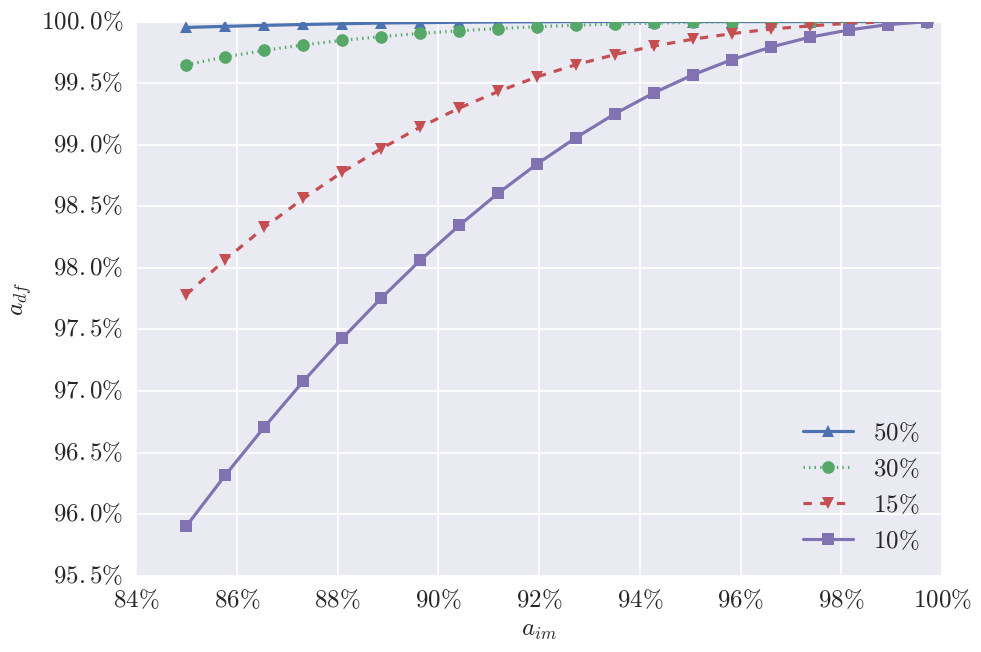

In [23]:
plt.plot(QUANTILES, ES_QUANTILES[0.5], '-^', label=r'$50\%%$')
plt.plot(QUANTILES, ES_QUANTILES[0.3], ':o', label=r'$30\%%$')
plt.plot(QUANTILES, ES_QUANTILES[0.15], '--v', label=r'$15\%%$')
plt.plot(QUANTILES, ES_QUANTILES[0.1], '-s', label=r'$10\%%$')

plt.xlabel(r'$a_{im}$', fontsize=labelsize)
plt.ylabel(r'$a_{df}$', fontsize=labelsize)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, pos: r"$%.0f\%%$" % (10**2 * y)))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, pos: r"$%.1f\%%$" % (10**2 * y)))

plt.legend(loc='best', fontsize=labelsize)

plt.tick_params(axis='both', which='major', labelsize=labelsize)

#plt.title('"Calibrated" default fund quantiles wrt perc. IM.')

plt.show()

In [24]:
ES_QUANTILES[0.5]

[0.999519995199017,
 0.999609996100454,
 0.999689996898718,
 0.9997599976015935,
 0.999819998200857,
 0.9998799987984741,
 0.9999099991007618,
 0.9999399994001257,
 0.9999699996997542,
 0.9999799998010048,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]